# 統計モデルでシグモイド+線形+２次関数の合成関数の切り替え点を求める

In [2]:
import cmdstanpy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cmdstanjupyter
import arviz
plt.style.use("ggplot")

In [3]:
# cmdstanpy.install_cmdstan()

In [4]:
%load_ext cmdstanjupyter

In [16]:
df = pd.read_parquet("../../customdataset/accum_curve_sigmoid_linear_quad.parquet")

In [19]:
df_sel = df.query("hour==0").copy()
df_sel["x_scale"] = df_sel["x"]/100

(0.0, 50.0)

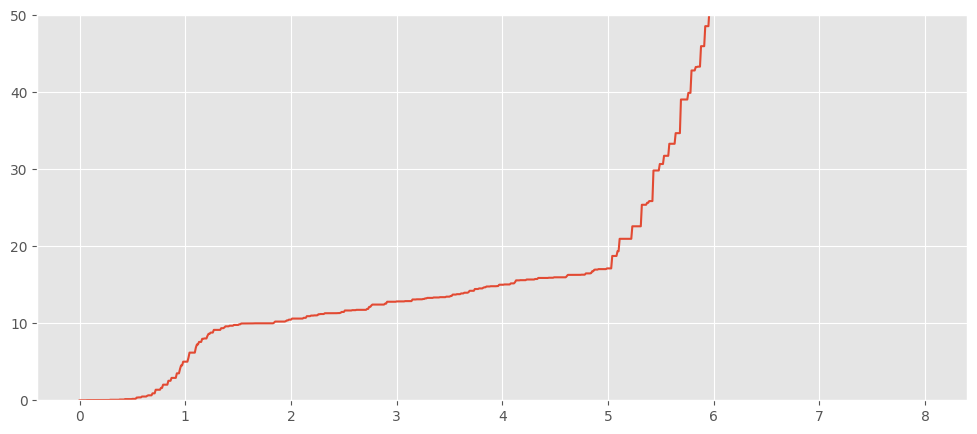

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_sel["x_scale"], df_sel["y"])
ax.set_ylim(0,50)

In [68]:
%%stan sigmoid_linear_quad
data {
    int N_X;
    vector[N_X] X;
    vector[N_X] y_price;           // 0..10 を想定
}
parameters {
    real<lower=5,upper=15> a;
    real<lower=0,upper=1.1> x0;  // シグモイド区間の変曲点
    real<lower=1e-6> sigma_y;      // 0 を避ける
    real<lower=1e-6,upper=1> delta;        // 中腹幅の下限（要調整）
    // 線形区間のパラメータ
    real<lower=1,upper=5> x1;
    real<lower=0.1,upper=5> alpha;
    // ２次関数区間のパラメータ
    real <lower=1> c1;
    real <lower=-500, upper=500>c2;
    real <lower=4,upper=8> x2;
}
transformed parameters {
    real k = (2.0 * log(9)) / delta;
    real c3 = -c1*x2*x2 -  c2*x2 +alpha*(x2-x1);
}
model {
    // 弱情報の事前（必要に応じて調整）
    a       ~ normal(9, 5);               // 上下限が 0..10 なら a≃10 付近
    sigma_y ~ normal(0, 1);
    vector[N_X] mu;
    mu =  a*inv_logit(k*(X-x0)) 
        + inv_logit(10*(X-x1)).*inv_logit(-10*(X-x2)).*(alpha*(X-x1))
        + inv_logit(10*(X-x2)).* (c1*X.*X + c2*X + c3);
    y_price ~ normal(mu, sigma_y);
  }

generated quantities {
    vector[N_X] y_new;
    vector[N_X] mu_new;
   
    for (n in 1:N_X)
    {
        mu_new[n] =  a*inv_logit(k*(X[n]-x0)) 
            + inv_logit(10*(X[n]-x1))*inv_logit(-10*(X[n]-x2))*(alpha*(X[n]-x1))
            + inv_logit(10*(X[n]-x2))* (c1*X[n]*X[n] + c2*X[n] + c3);
        y_new[n] = normal_rng(mu_new[n], sigma_y);
    }
}

INFO:cmdstanjupyter:Creating CmdStanPy model & assigning it to variable "sigmoid_linear_quad"
01:43:03 - cmdstanpy - INFO - compiling stan file /home/oonishi/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear_quad.stan to exe file /home/oonishi/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear_quad
01:43:19 - cmdstanpy - INFO - compiled model executable: /home/oonishi/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear_quad
INFO:cmdstanjupyter:StanModel now available as variable "sigmoid_linear_quad"!
 Compilation took 16 seconds.


In [66]:
model = cmdstanpy.CmdStanModel(stan_file="./.stan/sigmoid_linear_quad.stan")

ValueError: Failed to get source info for Stan model '/home/oonishi/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear_quad.stan'. Console:
Semantic error in '/home/oonishi/Git/pr_cmdstan/NoteBook/accum_curve_fitting/.stan/sigmoid_linear_quad.stan', line 40, column 8 to column 10:
   -------------------------------------------------
    38:      for (n in 1:N_X)
    39:      {
    40:          mu =  a*inv_logit(k*(X[n]-x0)) 
                 ^
    41:              + inv_logit(10*(X[n]-x1))*inv_logit(-10*(X[n]-x2))*(alpha*(X[n]-x1))
    42:              + inv_logit(10*(X[n]-x2))* (c1*X[n]*X[n] + c2*X[n] + c3);
   -------------------------------------------------

Identifier 'mu' not in scope. Did you mean 'X'?


In [52]:
df_sel = df[df["hour"].isin([0])]

In [53]:
df_sel["x_scale"] = df_sel["x"] /100
df_sel

/tmp/ipykernel_1751/354240167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["x_scale"] = df_sel["x"] /100


,x,y,phase,hour,p_sat,x_scale
0,0,0.000000,sigmoid,0,189.0,0.00
1,1,0.012181,sigmoid,0,189.0,0.01
2,2,0.012181,sigmoid,0,189.0,0.02
3,3,0.012181,sigmoid,0,189.0,0.03
4,4,0.012181,sigmoid,0,189.0,0.04
...,...,...,...,...,...,...
797,796,241.847988,quadratic,0,189.0,7.96
798,797,241.847988,quadratic,0,189.0,7.97
799,798,241.847988,quadratic,0,189.0,7.98
800,799,241.847988,quadratic,0,189.0,7.99


In [70]:
data = {
    "N_X":len(df_sel),
    "X":df_sel["x_scale"].values,
    "y_price":df_sel["y"].values
}

In [71]:
fit = sigmoid_linear_quad.sample(data=data,  chains=4, iter_warmup=1000, iter_sampling=1000,seed=1234, adapt_delta=0.9)

01:43:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

01:45:33 - cmdstanpy - INFO - CmdStan done processing.
01:45:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in 'sigmoid_linear_quad.stan', line 31, column 4 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in 'sigmoid_linear_quad.stan', line 31, column 4 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in 'sigmoid_linear_quad.stan', line 31, column 4 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in 'sigmoid_linear_quad.stan', line 31, column 4 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in 'sigmoid_linear_quad.stan', line 31, column 4 to column 34)
	Exception: normal_lpdf: Location parameter[1] is -nan, but must be finite! (in 'sigmoid_linear_quad.stan', line 31, column 4 to column 34)
	Exception: normal_lpdf: Location parame

In [72]:
dfres = fit.summary()
dfres.head(12)

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-270.68400,0.057515,2.221510,2.080090,-274.980000,-270.306000,-267.804000,1562.01,2311.24,1.00233
a,10.09210,0.003783,0.152252,0.145028,9.836080,10.095900,10.329000,1706.39,1907.97,1.00112
x0,1.00118,0.000215,0.009762,0.009526,0.985215,1.001200,1.017620,2105.64,2014.53,1.00076
sigma_y,0.85539,0.000377,0.021266,0.021654,0.821868,0.854760,0.891300,3198.76,2566.84,1.00149
delta,0.58209,0.000747,0.034713,0.033718,0.525887,0.581275,0.641238,2179.61,2233.37,1.00190
x1,1.82882,0.002091,0.082941,0.079097,1.692160,1.830850,1.960360,1676.53,1566.11,1.00208
alpha,2.22492,0.001089,0.053996,0.054915,2.136640,2.225460,2.313700,2477.85,2495.30,1.00038
c1,20.17950,0.001516,0.071738,0.069682,20.062300,20.179000,20.298200,2250.70,2635.21,1.00054
c2,-186.41100,0.019799,0.931450,0.911799,-187.950000,-186.404000,-184.892000,2222.25,2461.63,1.00048
x2,4.97006,0.000318,0.015016,0.014752,4.944570,4.970700,4.993380,2250.96,2643.88,1.00157


In [77]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

def func(x, dfres):
    a = dfres.loc["a", "Mean"]
    x0 = dfres.loc["x0", "Mean"]
    x1 = dfres.loc["x1", "Mean"]
    x2 = dfres.loc["x2", "Mean"]
    c1 = dfres.loc["c1","Mean"]
    c2 = dfres.loc["c2","Mean"]
    c3 = dfres.loc["c3","Mean"]
    k=dfres.loc["k","Mean"]
    alpha = dfres.loc["alpha", "Mean"]
    y1 =  a* sigmoid(k*(x-x0))
    y2 =  sigmoid(10*(x-x1))*sigmoid(-10*(x-x2)) * alpha*(x-x1)
    y3 = sigmoid(10*(x-x2))*(c1*x**2 + c2*x + c3)
    return y1 + y2 + y3

In [78]:
x = np.arange(0,10,0.1)
y = func(x,dfres)

In [81]:
df_sel["pred_Mean"] = dfres.filter(like="y_new",axis=0)["Mean"].values
df_sel["pred_5%"] = dfres.filter(like="y_new",axis=0)["5%"].values
df_sel["pred_95%"] = dfres.filter(like="y_new",axis=0)["95%"].values

/tmp/ipykernel_1751/311925609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["pred_Mean"] = dfres.filter(like="y_new",axis=0)["Mean"].values
/tmp/ipykernel_1751/311925609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel["pred_5%"] = dfres.filter(like="y_new",axis=0)["5%"].values
/tmp/ipykernel_1751/311925609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

(0.0, 50.0)

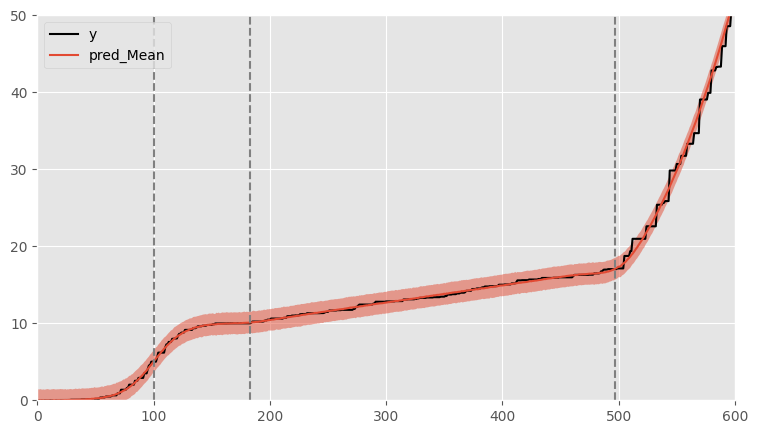

In [86]:
fig,ax = plt.subplots(figsize=(9,5))
df_sel[["y","pred_Mean"]].plot(ax=ax,color=["k","C0"])
ax.fill_between(df_sel.index,df_sel["pred_95%"], df_sel["pred_5%"],alpha=0.5)
ax.vlines(dfres.loc["x0","Mean"]*100,0,50,color="gray",ls="--")
ax.vlines(dfres.loc["x1","Mean"]*100,0,50, color="gray",ls="--")
ax.vlines(dfres.loc["x2","Mean"]*100,0,50, color="gray",ls="--")
ax.set_xlim(0,600)
ax.set_ylim(0,50)